In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-s49wra2h
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-s49wra2h
     |████████████████████████████████| 596 kB 4.3 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65106 sha256=4049d73def42b37f3666dc3d8a6de4a25eb7d8ab2b048d3b54757bd871a2c3b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ce8xj9tq/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.10.0+cu111'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13627, done.
remote: Counting objects: 100% (1128/1128), done.
remote: Compressing objects: 100% (606/606), done.
remote: Total 13627 (delta 705), reused 864 (delta 513), pack-reused 12499
Receiving objects: 100% (13627/13627), 5.82 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (9661/9661), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 1.9 MB/s 
     |████████████████████████████████| 145 kB 24.2 MB/s 
     |████████████████████████████████| 130 kB 44.8 MB/s 
     |████████████████████████████████| 749 kB 42.0 MB/s 
     |████████████████████████████████| 843 kB 33.0 MB/s 
     |████████████████████████████████| 112 kB 57.1 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=424e7c2020154da2380c54f98aff11c58c12dfc2be62ebf48be4c7249d471713
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9

In [1]:

import detectron2_repo
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


In [2]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"  # initialize from model zoo


In [3]:
from detectron2.modeling import build_model
model = build_model(cfg)  

In [4]:
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS) 

model_final_a3ec72.pkl: 254MB [00:21, 12.0MB/s]                           


{'__author__': 'Detectron2 Model Zoo'}

In [5]:
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [9]:
import numpy as np
import cv2 


def grabcut(img, final_mask):

  mask = final_mask[:,:,0].copy()

  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  x, y, w, h = bbox
  rect = (int(x),int(y), int(w)+1, int(h)+1)

  temp_mask = mask[int(y):int(y)+int(h)+1, int(x):int(x)+int(w)+1] == 1
  #mask[int(y):int(y)+int(h)+1, int(x):int(x)+int(w)+1] = (temp_mask*3)       # made mask region probable foreground

  cv2.grabCut(img,mask, rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

  return mask2


In [10]:
def get_mask(image, mask, img_num):

  final_mask = np.zeros_like(image)

  for c in range(final_mask.shape[-1]):
    final_mask[:,:,c] = mask.copy()

  mask2 = grabcut(image, final_mask)

  mask2 = np.repeat(mask2[:, :, np.newaxis], 3, axis=2)
  mask2 = cv2.GaussianBlur(mask2, (3, 3), 0)
  alpha = mask2.astype(float) * 1.1  # making blend stronger
  alpha[mask2 > 0] = 255
  alpha[alpha > 255] = 255
  alpha = alpha.astype(float)

  foreground = np.copy(image).astype(float)
  foreground[mask2 == 0] = 0
  background = np.ones_like(foreground, dtype=float) * 255

  cv2.imwrite(f'/content/foreground/{img_num}.png', foreground)
  cv2.imwrite(f'/content/alpha/{img_num}.png', alpha)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha / 255.0
  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
  # Add the masked foreground and background.
  cutout = cv2.add(foreground, background)

  cv2.imwrite(f'/content/background/{img_num}.png', background)

  cv2.imwrite(f'/content/cutout/{img_num}.png', cutout)

  return cutout


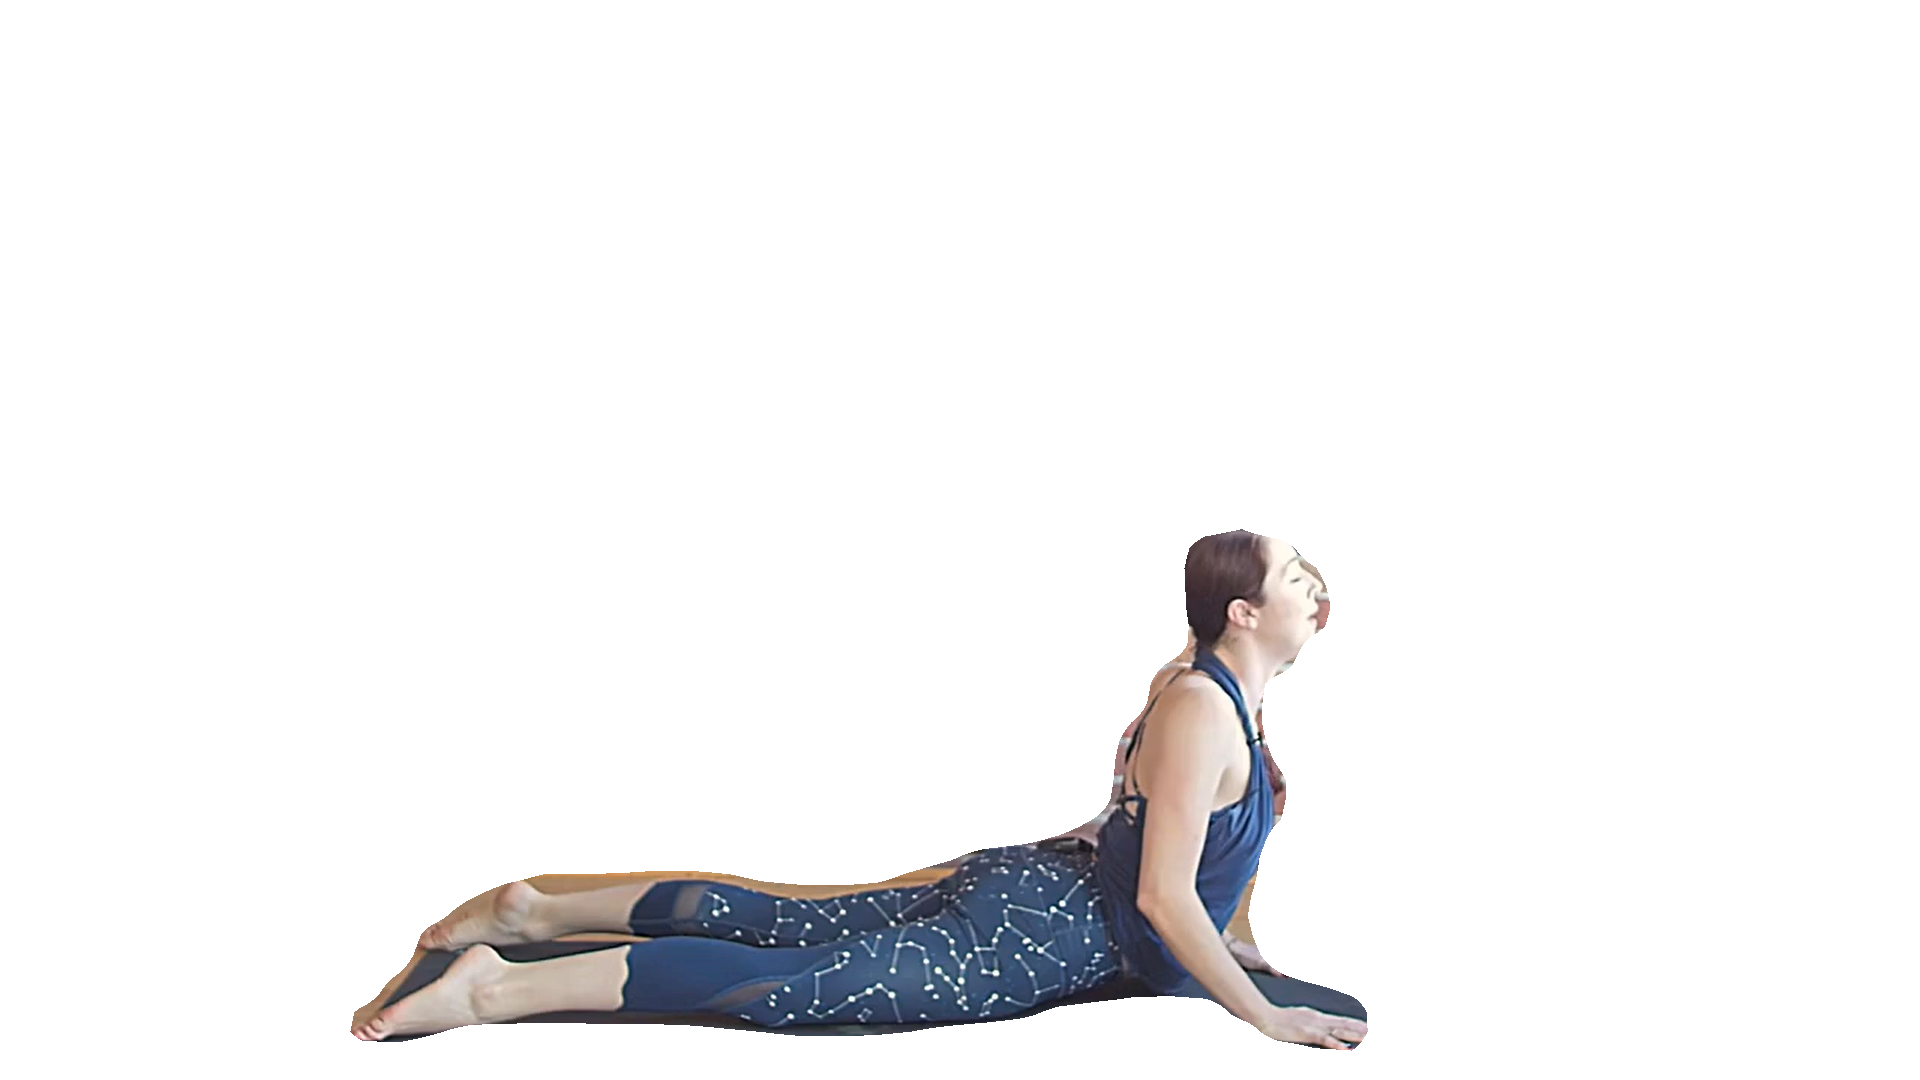

None

(1080, 1920, 3)


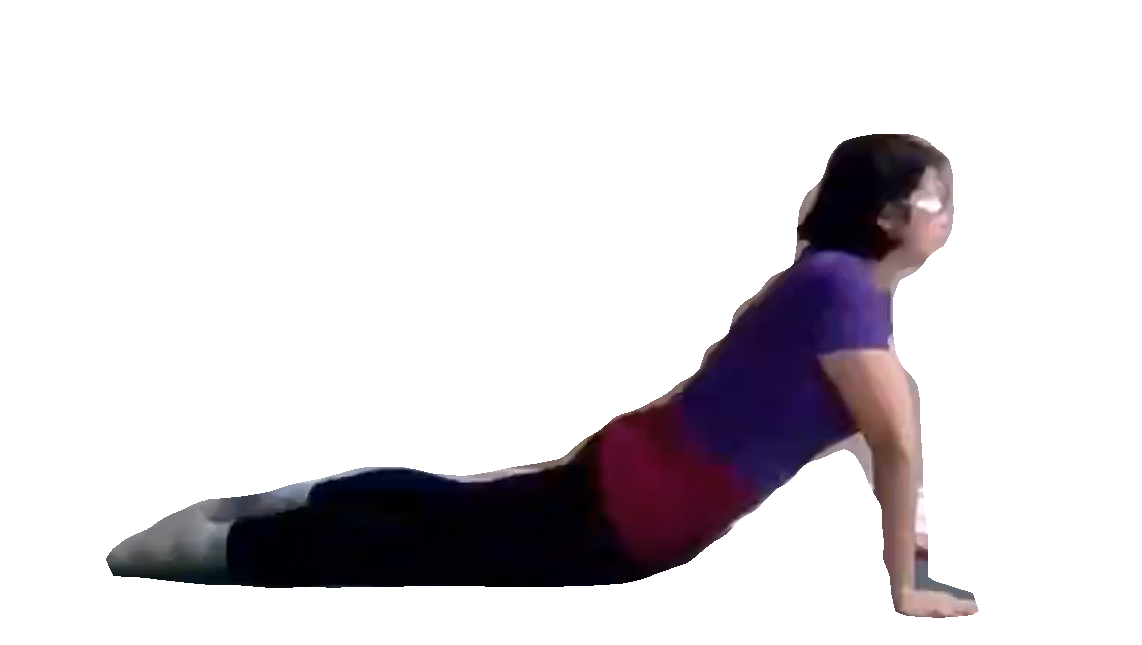

None

(645, 1142, 3)


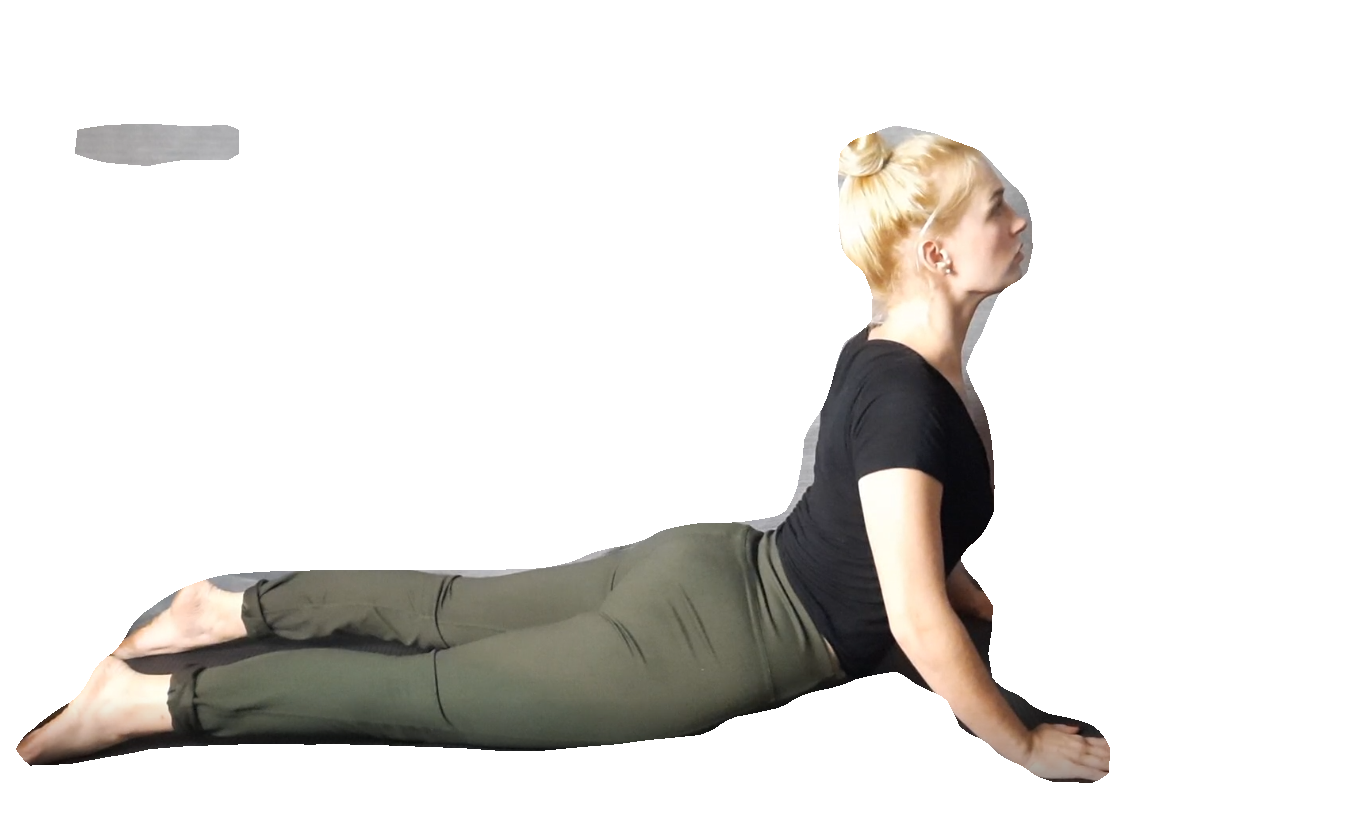

None

(827, 1363, 3)


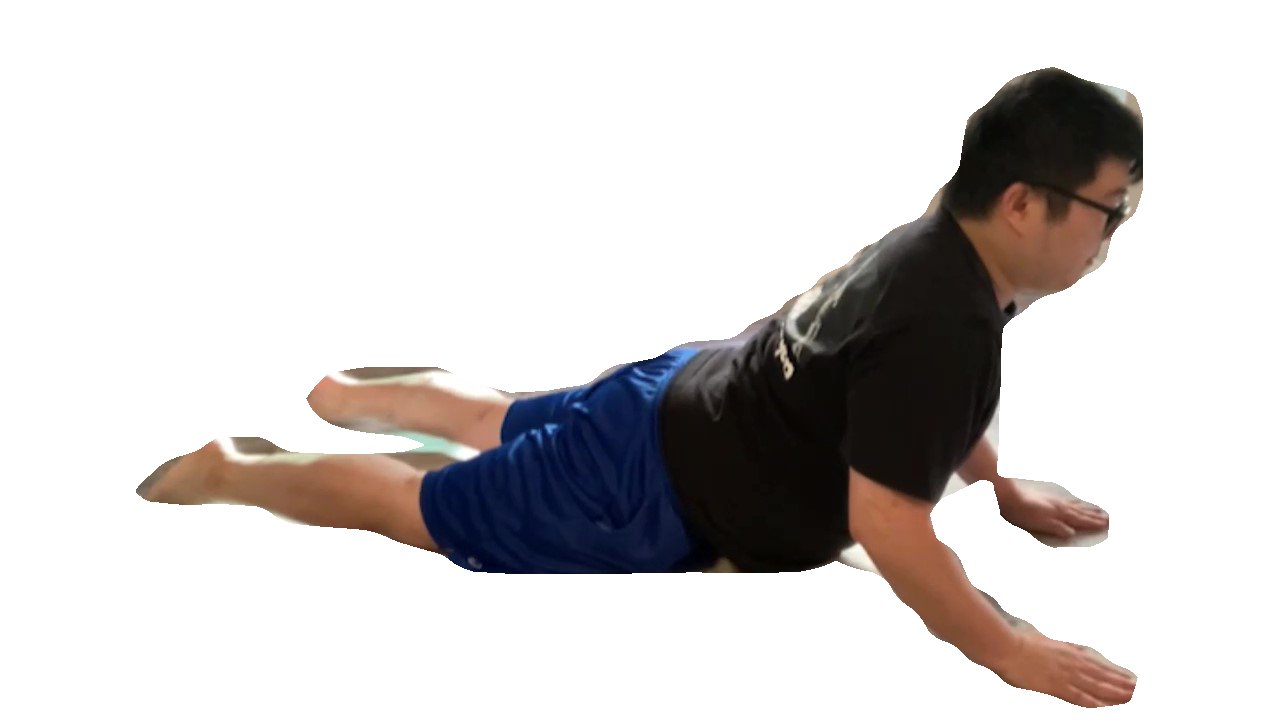

None

(720, 1280, 3)


In [11]:
from PIL import Image

img_dir = '/content/img_folder'

img_num = 4

for img in os.listdir(img_dir):

  pred = DefaultPredictor(cfg)
  image = cv2.imread(os.path.join(img_dir, img))
  outputs = pred(image)

  bbox = outputs['instances'].get('pred_boxes').tensor.cpu().tolist()[0]

  mask = outputs['instances'].get('pred_masks').cpu().numpy()[0]

  final_image = (get_mask(image.copy(), mask.copy(), img_num))

  img_num += 1

  display(cv2_imshow(final_image)),print(final_image.shape)